<a href="https://colab.research.google.com/github/iamviji/project/blob/master/MainModelOneHotMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf project
!git clone https://github.com/iamviji/project.git
!ls
!ls project
!pip install pyldpc
!pip install scikit-commpy



Cloning into 'project'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 128 (delta 51), reused 16 (delta 2), pack-reused 0
Receiving objects: 100% (128/128), 2.09 MiB | 2.84 MiB/s, done.
Resolving deltas: 100% (51/51), done.
project  sample_data
MainModel.ipynb		     MainModelOneHotMethodSoftMax.ipynb
MainModelKeras.ipynb	     MainModelWithSingleBERTraining.ipynb
MainModelKerasOneHot.ipynb   README.md
MainModelModCoding.ipynb     util.py
MainModelOneHotMethod.ipynb
     |████████████████████████████████| 1.1MB 2.7MB/s 
  Created wheel for pyldpc: filename=pyldpc-0.7.9-cp36-none-any.whl size=14306 sha256=d79121f7f07a50d9811ee00c059222fe8d4fc123e49ff7da49ddd65a1988cb49
  Stored in directory: /root/.cache/pip/wheels/47/7a/10/e94058ba8b0b6d98bf2719226d18d3dd6056525ad7b984c068
Successfully built pyldpc
     |████████████████████████████████| 51kB 1.6MB/s 


In [2]:
import pyldpc
import commpy
import numpy 
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior ()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
SNR_BEGIN = 0
SNR_END = 10
SNR_STEP_SIZE = 0.5
CHANEL_SIZE = 18
NUM_OF_INPUT_MESSAGE = 1000
LDPC_MAX_ITER = 100
num_parity_check = 3
num_bits_in_parity_check = 6 
input_message_length =  0 # Caculated by channel encoder and initialized later

In [4]:
def timer_update(i,current,time_tot,tic_incr=500):
    last = current
    current = time.time()
    t_diff = current-last
    print('SNR: {:04.3f} - Iter: {} - Last {} iterations took {:03.2f}s'.format(snr,i+1,tic_incr,t_diff))
    return time_tot + t_diff

def Snr2Sigma(snr):
  sigma = 10 ** (- snr / 20)
  return sigma

def pyldpc_encode (CodingMatrix, message):
  rng = pyldpc.utils.check_random_state(seed=None)
  d = pyldpc.utils.binaryproduct(CodingMatrix, message)
  encoded_message = (-1) ** d
  return encoded_message

def pyldpc_decode (ParityCheckMatrix, CodingMatrix, message, snr, maxiter):
  decoded_msg = pyldpc.decode(ParityCheckMatrix, message, snr, maxiter)
  out_message = pyldpc.get_message(CodingMatrix, decoded_msg)
  return out_message

awgn_channel_input = tf.compat.v1.placeholder(tf.float64, [CHANEL_SIZE])
awgn_noise_std_dev = tf.placeholder(tf.float64)
awgn_noise = tf.random.normal(tf.shape(awgn_channel_input), stddev=awgn_noise_std_dev, dtype=tf.dtypes.float64)
awgn_channel_output = tf.add(awgn_channel_input, awgn_noise)

init = tf.global_variables_initializer ()
sess = tf.Session ()
sess.run(init)

def AWGNChannelOutput (xx, snr , s):
  sigma = Snr2Sigma (snr)
  awgn_channel_output_message = s.run ([awgn_channel_output], feed_dict={noise_std_dev:sigma, channel_input:xx})
  return awgn_channel_output_message

In [5]:

ParityCheckMatrix, CodingMatrix = pyldpc.make_ldpc(CHANEL_SIZE, num_parity_check, num_bits_in_parity_check, systematic=True, sparse=True)
input_message_length = CodingMatrix.shape[1]
print ("input_message_size=", input_message_length, "channel_size=",CHANEL_SIZE)
print ("input_message_size=", CodingMatrix.shape[1], "channel_size=",CodingMatrix.shape[0])
input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE,input_message_length))
print (input_message)

input_message_size= 11 channel_size= 18
input_message_size= 11 channel_size= 18
[[1 0 1 ... 1 0 0]
 [0 1 0 ... 1 1 1]
 [0 0 1 ... 1 0 0]
 ...
 [0 0 0 ... 0 1 1]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 1]]


This section tries to compare BER and Time performance of PYLDPC in following 3 cases
1. SNR Noise function provided in encoder function of pyldpc library (pyldpc.encode)
2. SNR Noise function provided by commpy library (commpy.channels.awgn) 
3. SNR Noise function implemented using tensorflow 

In [6]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_tensor  = numpy.array(())
times_per_iter_tensor = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    sigma = Snr2Sigma (snr)
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})[0]
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      #print ("count=",abs(decoded_message-input_message[i]).sum())
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_tensor=numpy.append(ber_per_iter_tensor ,ber)
  times_per_iter_tensor=numpy.append(times_per_iter_tensor, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.79s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.40s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 5.10s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.76s
SNR: 0.000:
 -> BER: 0.57
 -> Total Time: 17.05s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.54s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.99s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 4.34s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.79s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 14.65s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.20s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.39s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.64s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.83s
SNR: 1.000:
 -> BER: 0.42
 -> Total Time: 12.05s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.88s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.85s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [7]:
# Here I am using commpy based AWGN 
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_awgn  = numpy.array(())
times_per_iter_awgn = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc_encode (CodingMatrix, input_message[i])
    awgn_channel_output_message = commpy.channels.awgn(encoded_message, snr)
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_awgn=numpy.append(ber_per_iter_awgn ,ber)
  times_per_iter_awgn=numpy.append(times_per_iter_awgn, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.63s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.12s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.65s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 6.20s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 15.61s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.36s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.72s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.95s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.20s
SNR: 0.500:
 -> BER: 0.52
 -> Total Time: 13.23s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.07s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.23s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.36s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.39s
SNR: 1.000:
 -> BER: 0.44
 -> Total Time: 11.05s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.98s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.91s
SNR: 1.500 - Iter: 750 - Last 250.0 it

In [8]:
# Here I am using tensor flow based AWGN, to make sure that effect of it is same as AWGN
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_pyldpc  = numpy.array(())
times_per_iter_pyldpc = numpy.array(())
for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  for i in range (NUM_OF_INPUT_MESSAGE):
    encoded_message = pyldpc.encode (CodingMatrix, input_message[i], snr)
    awgn_channel_output_message = encoded_message
    decoded_message = pyldpc_decode(ParityCheckMatrix, CodingMatrix, awgn_channel_output_message, snr, LDPC_MAX_ITER)
    if abs(decoded_message-input_message[i]).sum() != 0 :
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_pyldpc=numpy.append(ber_per_iter_pyldpc ,ber)
  times_per_iter_pyldpc=numpy.append(times_per_iter_pyldpc, total_time)

/usr/local/lib/python3.6/dist-packages/pyldpc/decoder.py:63: UserWarning: Decoding stopped before convergence. You may want
                       to increase maxiter
  to increase maxiter""")


SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 1.45s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 3.01s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 4.53s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 5.98s
SNR: 0.000:
 -> BER: 0.59
 -> Total Time: 14.98s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 1.23s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 2.51s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 3.73s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 5.14s
SNR: 0.500:
 -> BER: 0.49
 -> Total Time: 12.61s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 1.11s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 2.16s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 3.16s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 4.16s
SNR: 1.000:
 -> BER: 0.45
 -> Total Time: 10.59s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.76s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.64s
SNR: 1.500 - Iter: 750 - Last 250.0 it

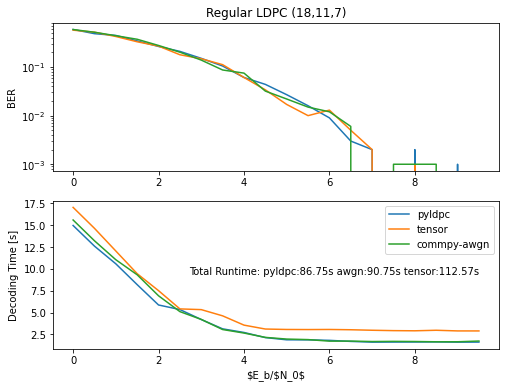

In [9]:
# Compare 3 AWGN(Tensorflow, CommPy, PYLDPC) Simulation on LDPC
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_pyldpc,'', label="pyldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="tensor") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_awgn,'', label="commpy-awgn") # plot BER vs SNR

ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
ax2.set_xlabel('$E_b/$N_0$')
ax2.set_ylabel('Decoding Time [s]')
ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
            xy=(1, 0.35), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

<B>Conclussion:</B>
      It proved that tensorflow behaves similar to AWGN noise channel provided by pyldpc, commpy. But tensor flow based one takes adds little more time delay. This need to be offseted if we are comparing performance. 

In [10]:
class GetOutOfLoop( Exception ):
    pass

In [40]:
# Define Model 
from keras.layers.normalization import BatchNormalization

# input_message_length is initialized by ldpc encoder
num_hidden_1 = CHANEL_SIZE
print ("input_message_length=", input_message_length)

lr_x = tf.placeholder(dtype=tf.float32,shape=[])
#batch_size_x = tf.placeholder(tf.int32,shape=[])
input_message_x_label = tf.placeholder("int32", [None], name="input_message_x_label")
input_message_x = tf.placeholder("float32", [None, 2**input_message_length], name="input_message_x")
awgn_noise_std_dev_x = tf.placeholder("float32", name ="awgn_noise_std_dev")
input_channel_x = tf.placeholder("float32", [None, CHANEL_SIZE], name="input_channel_x")

weights = {
  "encoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length, num_hidden_1], -1, 1), name="encoder_l1_weights"),
  "decoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1, 2**input_message_length], -1, 1), name="decoder_l1_weights"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length, 2**input_message_length], -1, 1), name="decoder_l2_weights"),
}

biases = {
  "encoder_l1" : tf.Variable (tf.random_uniform([num_hidden_1], -1,1), name="encoder_l1_bias"),
  "decoder_l1" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l1_bias"),
  "decoder_l2" : tf.Variable (tf.random_uniform([2**input_message_length], -1,1), name="decoder_l2_bias"),
}

def dl_encoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['encoder_l1']) + biases['encoder_l1'])
  #layer_2 = tf.round(layer_1)
  #layer_1 = BatchNormalization ()(layer_1)
  layer_2 =  layer_1 / tf.sqrt(tf.reduce_mean(tf.square(layer_1)))
  #layer_2 =  tf.nn.relu(layer_1)
  return layer_2

def dl_decoder (x):
  layer_1 = tf.nn.tanh (tf.matmul(x, weights['decoder_l1']) + biases['decoder_l1'])
  layer_2 = (tf.matmul(layer_1, weights['decoder_l2']) + biases['decoder_l2'])
  return layer_2

def awgn_layer(x):
  awgn_noise = tf.random.normal(tf.shape(x), stddev=awgn_noise_std_dev_x,  name="awgn_noise")
  awgn_channel_output = tf.add(x, awgn_noise, name ="x_and_noise")
  return awgn_channel_output


dl_encoder_output = dl_encoder(input_message_x)
dl_decoder_input = awgn_layer(dl_encoder_output)
#awgn_noise = tf.random.normal(tf.shape(dl_encoder_output), stddev=awgn_noise_std_dev,  name="awgn_noise")
#dl_decoder_input = tf.add(dl_encoder_output, awgn_noise, name ="x_and_noise")
dl_decoder_output = dl_decoder (dl_decoder_input)
dl_decoder_only_output = dl_decoder(input_channel_x)


#loss1 = tf.reduce_mean (-1 * (input_message_x*tf.log(dl_decoder_output) + (1 - input_message_x)*tf.log(1 - dl_decoder_output) ))
loss = tf.losses.sparse_softmax_cross_entropy(labels=input_message_x_label,logits=dl_decoder_output)
optimizer = tf.train.AdamOptimizer(learning_rate=lr_x).minimize (loss)

input_message_length= 11


In [41]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE*10))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(10000, 2048)
(1, 10000)


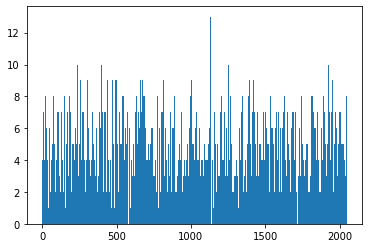

In [42]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
#training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
#y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message[0][:-1], bins = x_axis[:-1]) 
plt.show()


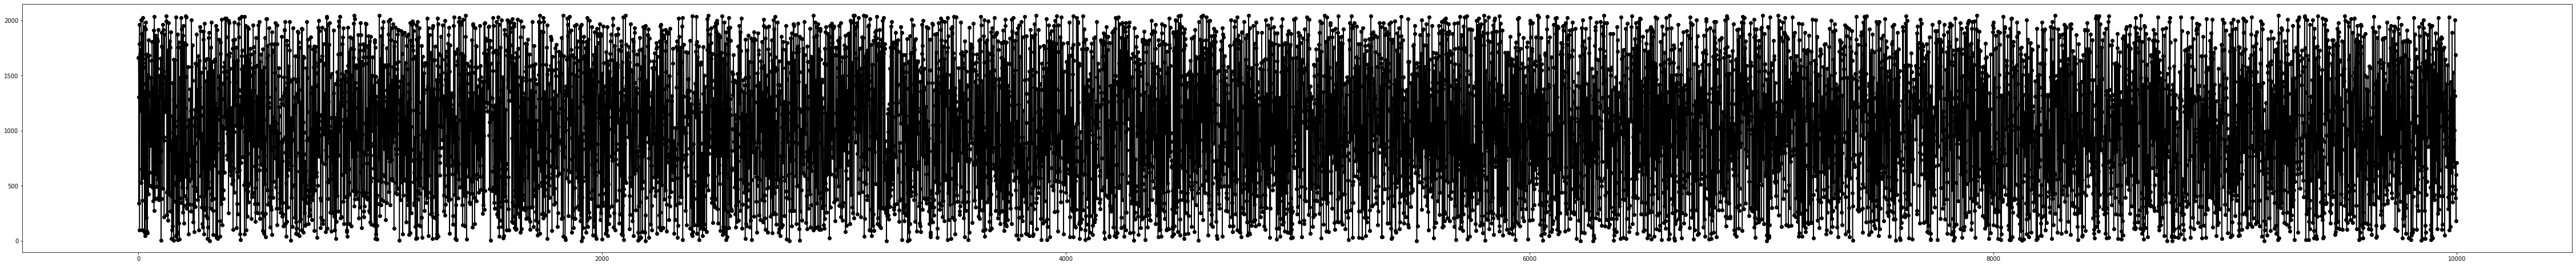

In [43]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE*10)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:-1],training_input_message[0][:-1], '-ok')


In [44]:
batch_size = 500

# Training
train_init = tf.global_variables_initializer ()
train_sess = tf.Session ()

epochs = 10
outer_ephocs = 1
display_step = 2
num_of_batches = training_input_message.shape[1] / batch_size
print ("batch_size:", batch_size, "num_of_batcches:", num_of_batches)
train_sess.run(train_init)
l = 0
lrate = 0.1
i = 0
snr_min = 9.5
snr_max = 10.5
snr_step_size = 0.5
max_iteration = epochs * num_of_batches * (snr_max - snr_min) / snr_step_size
print ("max iteration :",max_iteration,"num_of_batches:", num_of_batches)
try:
  for oe in range(outer_ephocs):
    for snr in (numpy.arange (0, 10, SNR_STEP_SIZE)):
    #for snr in (numpy.arange (snr_min, snr_max, SNR_STEP_SIZE)):
      sigma = 1.0*Snr2Sigma (snr)
      print ("Training for SNR=", snr, " sigma=", sigma, "iteratin:", oe) 
      for e in range(epochs):
        for j in range (int(num_of_batches)):
          i = i + 1
          x_train_batch_one_hot = training_input_message_one_hot [j*batch_size:(j+1)*batch_size]
          x_train_batch_one_hot = x_train_batch_one_hot.astype("float32")
          x_train_batch_label = training_input_message.reshape(training_input_message.shape[1]) [j*batch_size:(j+1)*batch_size]        
          if (i < 100): 
            lr = 0.1
          elif(i < 200):
            lr = 0.01
          else:
            lr = 0.001 
          _, l = train_sess.run ([optimizer, loss], feed_dict={input_message_x:x_train_batch_one_hot, awgn_noise_std_dev_x:sigma, lr_x:lr, input_message_x_label:x_train_batch_label.astype("int32")})
          if i % display_step == 0:          
            print('Step %i: Minibatch Loss: %f' % (i, l ))
          if (l < 0.05 and snr >= 9): 
            print ("Loss=", l)
            raise GetOutOfLoop
except GetOutOfLoop:
  print("Early Stop")

batch_size: 500 num_of_batcches: 20.0
max iteration : 400.0 num_of_batches: 20.0
Training for SNR= 0.0  sigma= 1.0 iteratin: 0
Step 2: Minibatch Loss: 123.848244
Step 4: Minibatch Loss: 151.601761
Step 6: Minibatch Loss: 144.024719
Step 8: Minibatch Loss: 141.715179
Step 10: Minibatch Loss: 139.990891
Step 12: Minibatch Loss: 142.260788
Step 14: Minibatch Loss: 130.267822
Step 16: Minibatch Loss: 137.039505
Step 18: Minibatch Loss: 135.297867
Step 20: Minibatch Loss: 128.377243
Step 22: Minibatch Loss: 139.398346
Step 24: Minibatch Loss: 129.219147
Step 26: Minibatch Loss: 127.736298
Step 28: Minibatch Loss: 132.481857
Step 30: Minibatch Loss: 124.693710
Step 32: Minibatch Loss: 135.078964
Step 34: Minibatch Loss: 130.720810
Step 36: Minibatch Loss: 129.799652
Step 38: Minibatch Loss: 132.663345
Step 40: Minibatch Loss: 128.867935
Step 42: Minibatch Loss: 109.739349
Step 44: Minibatch Loss: 121.191292
Step 46: Minibatch Loss: 127.842911
Step 48: Minibatch Loss: 126.906250
Step 50: Mini

In [47]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.59s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.26s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.88s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.45s
SNR: 0.000:
 -> BER: 0.52
 -> Total Time: 6.18s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.60s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.21s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.78s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.38s
SNR: 0.500:
 -> BER: 0.48
 -> Total Time: 5.97s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.59s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.17s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.81s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.44s
SNR: 1.000:
 -> BER: 0.37
 -> Total Time: 6.00s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.59s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.18s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

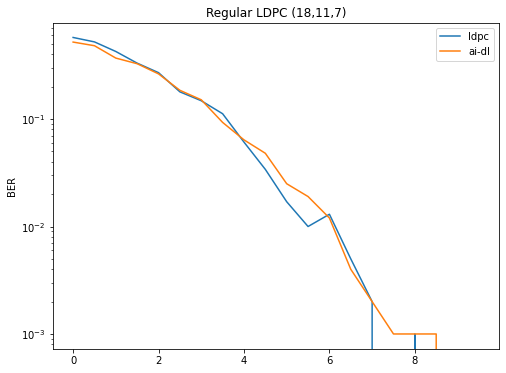

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()

In [49]:
import numpy
training_input_message = numpy.random.randint(2**input_message_length, size=(1,NUM_OF_INPUT_MESSAGE))
training_input_message_one_hot = numpy.zeros((training_input_message.size, 2**input_message_length))
training_input_message_one_hot[numpy.arange(training_input_message.size),training_input_message] = 1
print(training_input_message_one_hot)
print (training_input_message_one_hot.shape)
print (training_input_message.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(1000, 2048)
(1, 1000)


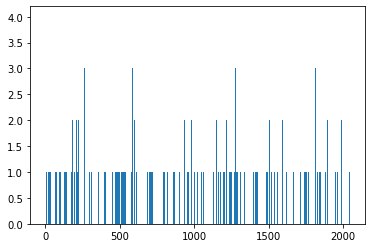

In [50]:
#input_message_length=8
#training_input_message = numpy.random.randint(2, size=(NUM_OF_INPUT_MESSAGE*10,input_message_length))
#training_input_message_decimal = row_bits2int(training_input_message)
#uniqueValues, indicesList = numpy.unique(training_input_message_decimal, return_index=True)
x_axis = numpy.arange(0,2**input_message_length)
#y_axis = row_bits2int(training_input_message)
#x=numpy.histogram(training_input_message_decimal,bins = x_axis) 
plt.hist(training_input_message[0][:-1], bins = x_axis[:-1]) 
plt.show()


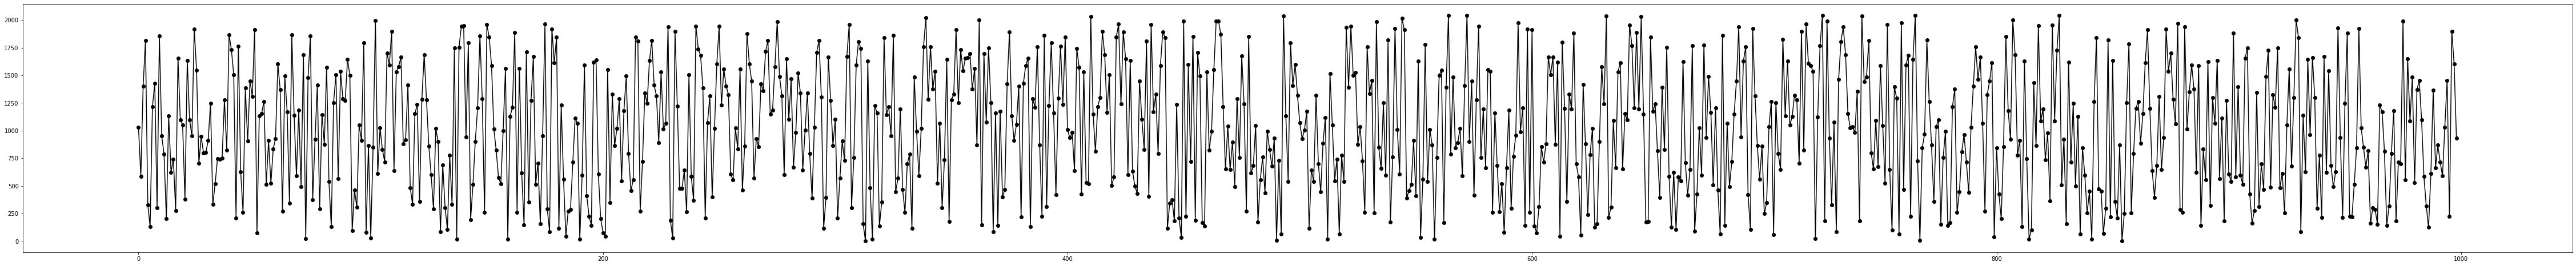

In [53]:
x_axis = numpy.arange(0,NUM_OF_INPUT_MESSAGE)
plt.figure(figsize=(80, 8))
plt.plot(x_axis[:-1],training_input_message[0][:-1], '-ok')


In [56]:
# Here I am using trained model
output_display_counter = NUM_OF_INPUT_MESSAGE/4
ber_per_iter_dl_tensor  = numpy.array(())
times_per_iter_dl_tensor = numpy.array(())

for snr in numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE):
  total_bit_error = 0
  total_msg_error = 0
  total_time = 0
  current_time = time.time()
  lrate = 0.001
  sigma = Snr2Sigma (snr)
  for i in range (NUM_OF_INPUT_MESSAGE):
    input_message_xx = training_input_message_one_hot [i:i+1]
    input_message_xx = input_message_xx.astype("float32")
    #,input_message_x_label:training_input_message [i]
    encoded_message = train_sess.run ([dl_encoder_output], feed_dict={input_message_x:input_message_xx })
    encoded_message = encoded_message[0][0]
    #encoded_message = numpy.around(encoded_message[0][0]> 0).astype(int)
    #print (encoded_message[0][0])
    awgn_channel_output_message = sess.run ([awgn_channel_output], feed_dict={awgn_noise_std_dev:sigma, awgn_channel_input:encoded_message})
    #print (awgn_channel_output_message)
    decoded_message = train_sess.run ([dl_decoder_only_output], feed_dict={input_channel_x:awgn_channel_output_message})
    #print ("input", input_message[i])
    #decoded_message = numpy.around(decoded_message[0][0]> 0).astype(int)
    #rint ("output", decoded_message)
    #print ("output", numpy.argmax(training_input_message_one_hot[i]), numpy.argmax(decoded_message[0][0]))
    if (numpy.argmax(training_input_message_one_hot[i]) != numpy.argmax(decoded_message[0][0])):
      total_msg_error = total_msg_error + 1
    if (i+1) % output_display_counter == 0:
      total_time = timer_update(i, current_time,total_time, output_display_counter)
  ber = float(total_msg_error)/NUM_OF_INPUT_MESSAGE
  print('SNR: {:04.3f}:\n -> BER: {:03.2f}\n -> Total Time: {:03.2f}s'.format(snr,ber,total_time))
  ber_per_iter_dl_tensor=numpy.append(ber_per_iter_dl_tensor ,ber)
  times_per_iter_dl_tensor=numpy.append(times_per_iter_dl_tensor, total_time)

SNR: 0.000 - Iter: 250 - Last 250.0 iterations took 0.60s
SNR: 0.000 - Iter: 500 - Last 250.0 iterations took 1.22s
SNR: 0.000 - Iter: 750 - Last 250.0 iterations took 1.81s
SNR: 0.000 - Iter: 1000 - Last 250.0 iterations took 2.41s
SNR: 0.000:
 -> BER: 0.53
 -> Total Time: 6.03s
SNR: 0.500 - Iter: 250 - Last 250.0 iterations took 0.60s
SNR: 0.500 - Iter: 500 - Last 250.0 iterations took 1.21s
SNR: 0.500 - Iter: 750 - Last 250.0 iterations took 1.81s
SNR: 0.500 - Iter: 1000 - Last 250.0 iterations took 2.41s
SNR: 0.500:
 -> BER: 0.47
 -> Total Time: 6.04s
SNR: 1.000 - Iter: 250 - Last 250.0 iterations took 0.59s
SNR: 1.000 - Iter: 500 - Last 250.0 iterations took 1.18s
SNR: 1.000 - Iter: 750 - Last 250.0 iterations took 1.76s
SNR: 1.000 - Iter: 1000 - Last 250.0 iterations took 2.30s
SNR: 1.000:
 -> BER: 0.42
 -> Total Time: 5.83s
SNR: 1.500 - Iter: 250 - Last 250.0 iterations took 0.58s
SNR: 1.500 - Iter: 500 - Last 250.0 iterations took 1.18s
SNR: 1.500 - Iter: 750 - Last 250.0 itera

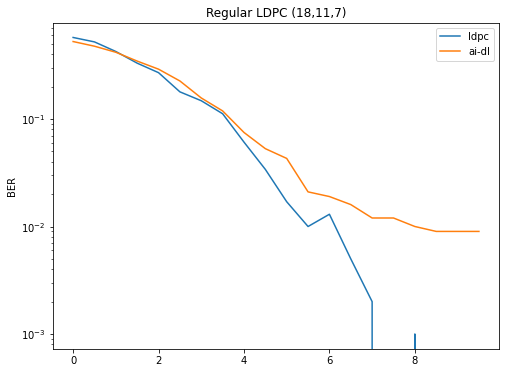

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
snrs = numpy.arange (SNR_BEGIN, SNR_END, SNR_STEP_SIZE)
fig, (ax1) = plt.subplots(1,1,figsize=(8,6))
ax1.semilogy(snrs,ber_per_iter_tensor,'', label="ldpc") # plot BER vs SNR
ax1.semilogy(snrs,ber_per_iter_dl_tensor,'', label="ai-dl") # plot BER vs SNR
ax1.set_ylabel('BER')
ax1.set_title('Regular LDPC ({},{},{})'.format(CHANEL_SIZE,input_message_length,CHANEL_SIZE-input_message_length))
#ax2.plot(snrs,times_per_iter_pyldpc,'', label="pyldpc") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_tensor,'', label="tensor") # plot decode timing for different SNRs
#ax2.plot(snrs,times_per_iter_awgn,'', label="commpy-awgn") # plot decode timing for different SNRs
#ax2.set_xlabel('$E_b/$N_0$')
#ax2.set_ylabel('Decoding Time [s]')
#ax2.annotate('Total Runtime: pyldpc:{:03.2f}s awgn:{:03.2f}s tensor:{:03.2f}s'.format(numpy.sum(times_per_iter_pyldpc), 
#            numpy.sum(times_per_iter_awgn), numpy.sum(times_per_iter_tensor)),
#            xy=(1, 0.35), xycoords='axes fraction',
#            xytext=(-20, 20), textcoords='offset pixels',
#            horizontalalignment='right',
#            verticalalignment='bottom')
plt.savefig('ldpc_ber_{}_{}.png'.format(CHANEL_SIZE,input_message_length))
plt.legend ()
plt.show()